# Fourier continuations of third kind

This notebook implements Fourier continuations of the third kind with iterative refinement and overcollocation to decompose a non-periodic function into plane waves. It studies how to best carry out the periodic extension of an arbitrary, complex funtion.

### Start with decomposition into plane waves

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import scipy 

In [2]:
def getFPICSUMatrix(N, Ncoll, theta, chi): 
    x = np.zeros(Ncoll)
    M = np.zeros((Ncoll, N), dtype=complex)
    for i in range(Ncoll):
        for j in range(N):
            #Collocation points uniformly distributed over the positive half
            #of the physical interval x in [0, chi]
            x[i]    = i * chi / (Ncoll - 1) 
            M[i, j] = np.exp(1j * j * np.pi / theta * x[i])
    return M, x

def invertComplexM(M, cutoff):
    U, s, Vh = scipy.linalg.svd(M)
    sinv = np.zeros(M.T.shape, dtype=complex)
    for i in range(np.min(M.shape)):
        if s[i] < cutoff:
            sinv[i, i] = 0
        else:
            sinv[i, i] = 1/s[i]
    return Vh.T.conjugate() @ sinv @ U.T.conjugate()

Reproduce figure 8


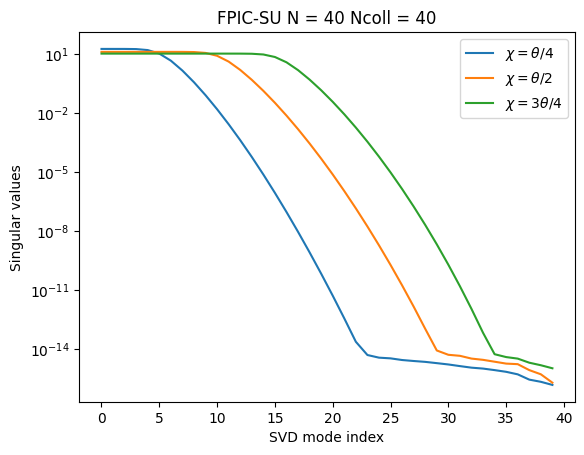

In [3]:

N     = 40
Ncoll = N

#The extended domain is split up into the physical and extension parts
#  [-theta, -chi, chi, theta]
theta = np.pi    # extension domain boundary
plt.title(f"FPIC-SU N = {N} Ncoll = {Ncoll}")
plt.ylabel("Singular values")
plt.xlabel("SVD mode index") 
plt.yscale("log") 

chis   = [theta/4, theta/2, 3*theta/4]  # physical domain boundary
labels = [r"$\chi = \theta/4$", r"$\chi = \theta/2$", r"$\chi = 3\theta/4$"]

for chi, label in zip(chis, labels): 
    M, x = getFPICSUMatrix(N, Ncoll, theta, chi) 
    y = scipy.linalg.svdvals(M, overwrite_a=False, check_finite=True)
    x = np.arange(len(y))
    plt.plot(x, y, label=label)
plt.legend()
plt.show()

Compute pseudoinverse of matrix using SVD:

For any matrix $M \in \mathbb{R}^{m\times n}$ , there exist orthogonal matrices $M \in \mathbb{R}^{m\times m}$ and $V \in \mathbb{R}^{n\times n}$ and scalars $σ_1 , . . . , σ_n$ such that
$$ M = U S V^T$$

In [4]:
chi = theta/2 

M, x = getFPICSUMatrix(N, Ncoll, theta, chi) 
#Factorizes the matrix a into two unitary matrices U and Vh, and a 1-D array s of singular values (real, non-negative) such that a == U @ S @ Vh, where S is a suitably shaped matrix of zeros with main diagonal s.
U, s, Vh = scipy.linalg.svd(M)

Compute pseudoinverse by inverting $S$ with cutoff

In [5]:


#Test implementation of invert M
A = np.random.rand(32, 32) + 1j * np.random.rand(32, 32)
np.testing.assert_allclose(np.abs(scipy.linalg.inv(A) - invertComplexM(A, 0)), 0, atol=1e-13)


Finally compute the periodic extension of an arbitrary complex function ($f(x) = e^x + i e^x $ in this example)

/home/calab912/.local/lib/python3.8/site-packages/matplotlib/transforms.py:2877: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


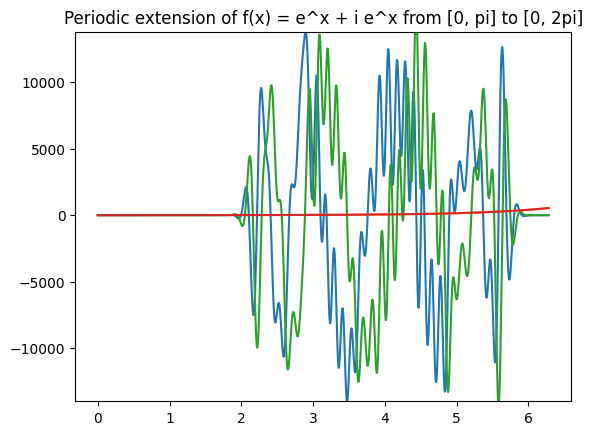

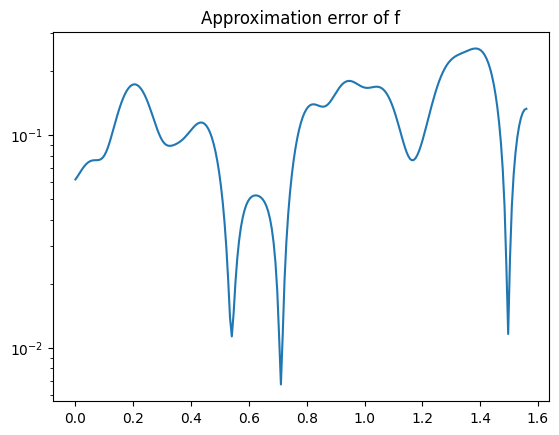

In [6]:
N     = 64
Ncoll = N
theta = np.pi
chi   = theta/2 
M, x  = getFPICSUMatrix(N, Ncoll, theta, chi) 

def func(x):
    return np.exp(x) + 1j * np.exp(x) 

f     = func(x) 
Minv  = invertComplexM(M, 1e-14)
a     = Minv @ f

def reconstruct(x, a, theta): 
    rec = np.zeros(x.shape, dtype=complex) 
    for j, coeff in enumerate(a): 
        rec += coeff * np.exp(1j * np.pi / theta * j * x)
    return rec

xext = np.linspace(0, 2*theta, 1000)
frec = reconstruct(xext, a, theta) 

plt.title("Periodic extension of f(x) = e^x + i e^x from [0, pi] to [0, 2pi]")
plt.plot(xext, frec.real,       label="Real Extension") 
plt.plot(xext, func(xext).real, label="Real Original") 
plt.plot(xext, frec.imag,       label="Imag Extension") 
plt.plot(xext, func(xext).imag, label="Imag Original") 
plt.ylim(np.min(frec) - 1, np.max(frec) + 1)
plt.show() 
plt.title("Approximation error of f")
ul = np.argwhere(xext<chi)[-1][0]
xorg = xext[:ul]
plt.yscale("log")
plt.plot(xorg, np.abs(func(xorg) - frec[:ul]))
plt.show() 

Improve this result by using iterative refinement

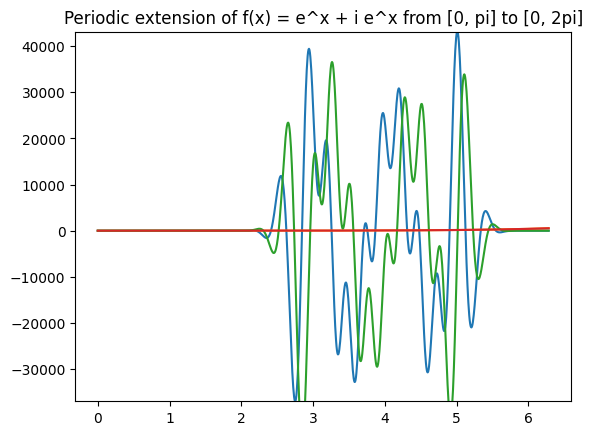

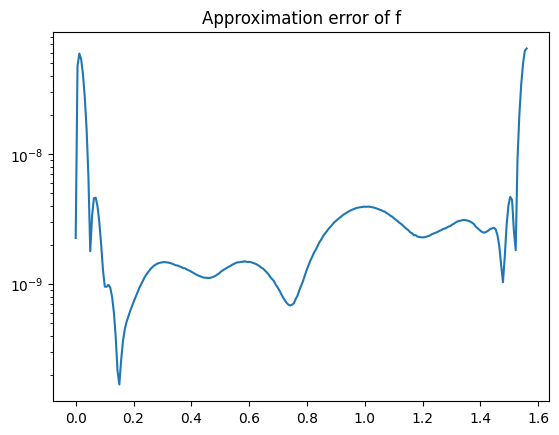

In [7]:
def iterativeRefinement(M, Minv, f, threshold = 100, maxiter = 5): 
    a       = Minv @ f
    r       = M @ a - f
    counter = 0
    while np.linalg.norm(r) > 100 * np.finfo(float).eps * np.linalg.norm(a) and counter < maxiter: 
        delta    = Minv @ r
        a        = a - delta 
        r        = M @ a - f
        counter += 1
    return a

N     = 32
Ncoll = N
theta = np.pi
chi   = theta/2 
M, x  = getFPICSUMatrix(N, Ncoll, theta, chi) 

def func(x):
    return np.exp(x) + 1j * np.exp(x) 

f     = func(x) 
Minv  = invertComplexM(M, 1e-14)
a     = iterativeRefinement(M, Minv, f, threshold = 10, maxiter = 3)

xext = np.linspace(0, 2*theta, 1000)
frec = reconstruct(xext, a, theta) 

plt.title("Periodic extension of f(x) = e^x + i e^x from [0, pi] to [0, 2pi]")
plt.plot(xext, frec.real,       label="Real Extension") 
plt.plot(xext, func(xext).real, label="Real Original") 
plt.plot(xext, frec.imag,       label="Imag Extension") 
plt.plot(xext, func(xext).imag, label="Imag Original") 
plt.ylim(np.min(frec) - 1, np.max(frec) + 1)
plt.show() 
plt.title("Approximation error of f")
ul = np.argwhere(xext<chi)[-1][0]
xorg = xext[:ul]
plt.yscale("log")
plt.plot(xorg, np.abs(func(xorg) - frec[:ul]))
plt.show() 

We see that decomposition into plane waves works in principle but leads to very large function values in the extension domain, strong oscillatory behaviour and less than ideal reconstruction of the original function. 

### Can we get a better result by splitting everything into symmetric and antisymmetric parts and doing 4 real SVDs?

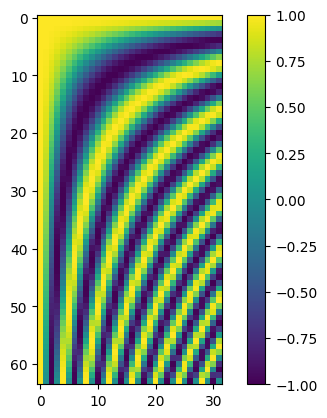

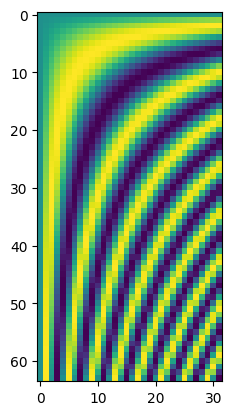

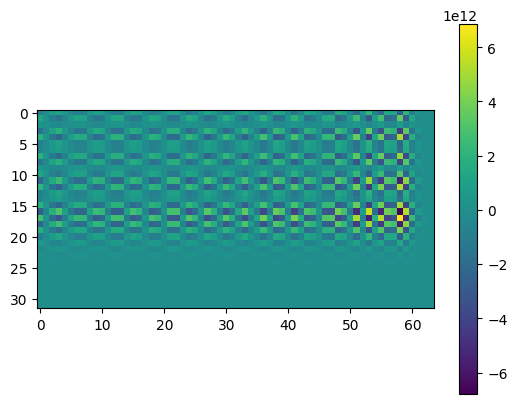

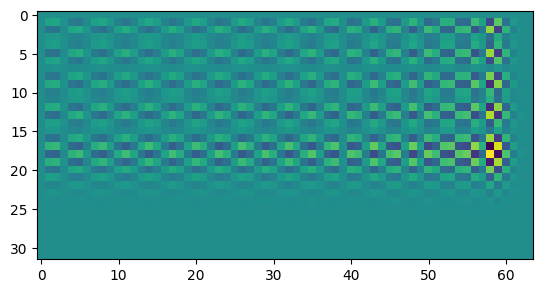

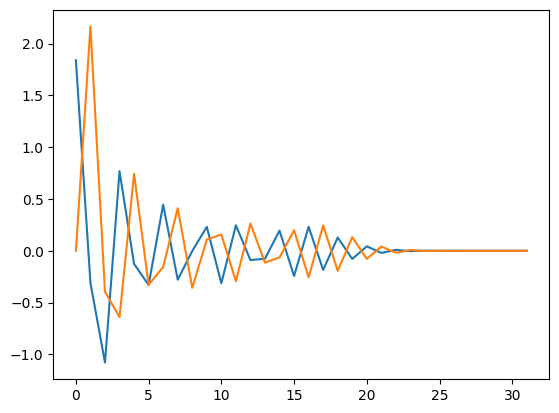

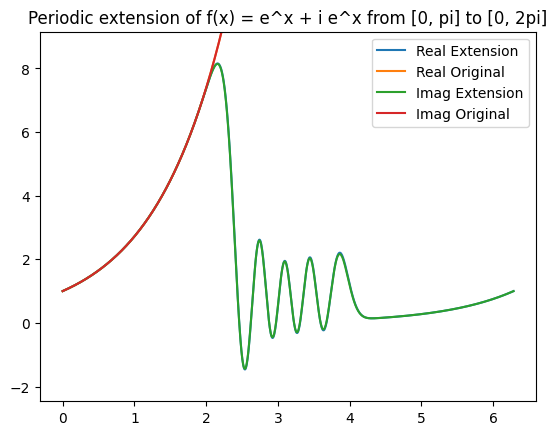

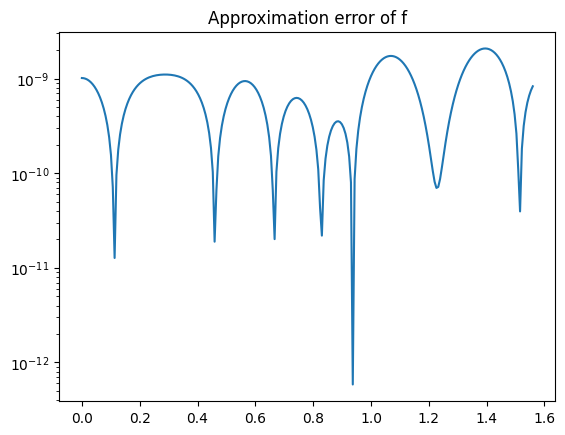

In [8]:
def getFPICSUEvenMatrix(N, Ncoll, theta, chi): 
    x = np.zeros(Ncoll)
    M = np.zeros((Ncoll, N))
    for i in range(Ncoll):
        for j in range(N):
            #Collocation points uniformly distributed over the positive half
            #of the physical interval x in [0, chi]
            x[i]    = i * chi / (Ncoll - 1) 
            M[i, j] = np.cos(j * np.pi / theta * x[i])
    return M, x

def getFPICSUOddMatrix(N, Ncoll, theta, chi): 
    x = np.zeros(Ncoll)
    M = np.zeros((Ncoll, N))
    for i in range(Ncoll):
        for j in range(N):
            #Collocation points uniformly distributed over the positive half
            #of the physical interval x in [0, chi]
            x[i]    = i * chi / (Ncoll - 1) 
            M[i, j] = np.sin(j * np.pi / theta * x[i])
    return M, x

def invertRealM(M, cutoff):
    U, s, Vh = scipy.linalg.svd(M)
    sinv = np.zeros(M.T.shape)
    for i in range(np.min(M.shape)):
        if s[i] < cutoff:
            sinv[i, i] = 0
        else:
            sinv[i, i] = 1/s[i]
    return Vh.T @ sinv @ U.T


def reconstructOdd(x, a, theta): 
    rec = np.zeros(x.shape) 
    for j, coeff in enumerate(a): 
        rec += coeff * np.sin(np.pi / theta * j * x)
    return rec

def reconstructEven(x, a, theta): 
    rec = np.zeros(x.shape) 
    for j, coeff in enumerate(a): 
        rec += coeff * np.cos(np.pi / theta * j * x)
    return rec

def iterativeRefinement(M, Minv, f, threshold = 100, maxiter = 5): 
    a       = Minv @ f
    r       = M @ a - f
    counter = 0
    while np.linalg.norm(r) > 100 * np.finfo(float).eps * np.linalg.norm(a) and counter < maxiter: 
        delta    = Minv @ r
        a        = a - delta 
        r        = M @ a - f
        counter += 1
    return a


N     = 32
Ncoll = N * 2
theta = np.pi
chi   = theta/2 
Meven, x  = getFPICSUEvenMatrix(N, Ncoll, theta, chi) 
Modd,  x  = getFPICSUOddMatrix (N, Ncoll, theta, chi) 

def func(x):
    return np.exp(x) + 1j * np.exp(x) 

Meveninv  = invertRealM(Meven, 1e-14)
Moddinv   = invertRealM(Modd,  1e-14)


plt.imshow(Meven)
plt.colorbar()
plt.show()
plt.imshow(Modd)
plt.show()
plt.imshow(Meveninv)
plt.colorbar()
plt.show()
plt.imshow(Moddinv)
plt.show()

xext = np.linspace(0, 2*theta, 1000)

f      = func(x)
feven  = (func(x) + func(-x)).real/2
fodd   = (func(x) - func(-x)).real/2
aeven  = iterativeRefinement(Meven, Meveninv, feven, threshold = 10, maxiter = 3)
aodd   = iterativeRefinement(Modd,  Moddinv,  fodd,  threshold = 10, maxiter = 3)
plt.plot(aeven)
plt.plot(aodd)
plt.show()
freal  = reconstructOdd(xext, aodd, theta) + reconstructEven(xext, aeven, theta) 
feven  = (func(x) + func(-x)).imag/2
fodd   = (func(x) - func(-x)).imag/2
aeven  = iterativeRefinement(Meven, Meveninv, feven, threshold = 10, maxiter = 10)
aodd   = iterativeRefinement(Modd,  Moddinv,  fodd,  threshold = 10, maxiter = 10)
fimag  = reconstructOdd(xext, aodd, theta) + reconstructEven(xext, aeven, theta) 
frec   = freal + 1j * fimag

plt.title("Periodic extension of f(x) = e^x + i e^x from [0, pi] to [0, 2pi]")
plt.plot(xext, frec.real,       label="Real Extension") 
plt.plot(xext, func(xext).real, label="Real Original") 
plt.plot(xext, frec.imag,       label="Imag Extension") 
plt.plot(xext, func(xext).imag, label="Imag Original") 
plt.legend()
plt.ylim(np.min(frec) - 1, np.max(frec) + 1)
plt.show() 
plt.title("Approximation error of f")
ul = np.argwhere(xext<chi)[-1][0]
xorg = xext[:ul]
plt.yscale("log")
plt.plot(xorg, np.abs(func(xorg) - frec[:ul]))
plt.show() 

## The slow all-in-one solution

In [9]:
class FourierExtension:
    def __init__(self, N, Ncoll, theta, chi, cutoff):
        self.N, self.Ncoll, self.theta, self.chi, self.cutoff = N, Ncoll, theta, chi, cutoff 
        self.Meven = self.getFPICSUEvenMatrix(N, Ncoll, theta, chi) 
        self.Modd  = self.getFPICSUOddMatrix (N, Ncoll, theta, chi) 

        self.dx    = chi / (Ncoll - 1) 
        self.x     = np.arange(-Ncoll + 1, Ncoll) * self.dx


        self.Meveninv  = self.invertRealM(self.Meven, cutoff)
        self.Moddinv   = self.invertRealM(self.Modd,  cutoff)

    def getX(self): 
        return self.x, self.dx
    
    def getFPICSUEvenMatrix(self, N, Ncoll, theta, chi): 
        M  = np.zeros((Ncoll, N))
        dx = chi / (Ncoll - 1) 
        for i in range(Ncoll):
            for j in range(N):
                #Collocation points uniformly distributed over the positive half
                #of the physical interval x in [0, chi]
                M[i, j] = np.cos(j * np.pi / theta * i * dx)
        return M

    def getFPICSUOddMatrix(self, N, Ncoll, theta, chi): 
        M = np.zeros((Ncoll, N))
        dx = chi / (Ncoll - 1) 
        for i in range(Ncoll):
            for j in range(N):
                #Collocation points uniformly distributed over the positive half
                #of the physical interval x in [0, chi]
                M[i, j] = np.sin(j * np.pi / theta * i * dx)
        return M

    def invertRealM(self, M, cutoff):
        U, s, Vh = scipy.linalg.svd(M)
        sinv = np.zeros(M.T.shape)
        for i in range(np.min(M.shape)):
            if s[i] < cutoff:
                sinv[i, i] = 0
            else:
                sinv[i, i] = 1/s[i]
        return Vh.T @ sinv @ U.T


    def reconstructOdd(self, x, a, theta): 
        rec = np.zeros(x.shape, dtype=complex) 
        for j, coeff in enumerate(a): 
            rec += coeff * np.sin(np.pi / theta * j * x)
        return rec

    def reconstructEven(self, x, a, theta): 
        rec = np.zeros(x.shape, dtype=complex) 
        for j, coeff in enumerate(a): 
            rec += coeff * np.cos(np.pi / theta * j * x)
        return rec
    
    def reconstruct(self, x, aodd, aeven, theta): 
        rec = np.zeros(x.shape, dtype=complex) 
        for j, (oddcoeff, evecoeff) in enumerate(zip(aodd, aeven)): 
            rec += ( evecoeff / ( 2 * 1 ) + oddcoeff / ( 2 * 1j ) ) * ( np.exp(+ 1j * np.pi / theta * j * x) )
        for j, (oddcoeff, evecoeff) in enumerate(zip(aodd, aeven)): 
            rec += ( evecoeff / ( 2 * 1 ) - oddcoeff / ( 2 * 1j ) ) * ( np.exp(- 1j * np.pi / theta * j * x) )
        return rec
    
    
    def iterativeRefinement(self, M, Minv, f, threshold = 100, maxiter = 5): 
        a       = Minv @ f
        r       = M @ a - f
        counter = 0
        while np.linalg.norm(r) > 100 * np.finfo(float).eps * np.linalg.norm(a) and counter < maxiter: 
            delta    = Minv @ r
            a        = a - delta 
            r        = M @ a - f
            counter += 1
        return a

    def computeExtension(self, f, xext, threshold = 10, maxiter = 3): 
        refeven  = ((f + np.flip(f)).real/2)[self.Ncoll-1:]
        refodd   = ((f - np.flip(f)).real/2)[self.Ncoll-1:]
        imfeven  = ((f + np.flip(f)).imag/2)[self.Ncoll-1:]
        imfodd   = ((f - np.flip(f)).imag/2)[self.Ncoll-1:]
        aeven    = self.iterativeRefinement(self.Meven, self.Meveninv, refeven, threshold = threshold, maxiter = maxiter) + 1j * self.iterativeRefinement(self.Meven, self.Meveninv, imfeven, threshold = threshold, maxiter = maxiter)
        aodd     = self.iterativeRefinement(self.Modd,  self.Moddinv,  refodd,  threshold = threshold, maxiter = maxiter) + 1j * self.iterativeRefinement(self.Modd,  self.Moddinv,  imfodd,  threshold = threshold, maxiter = maxiter)
        frec     = self.reconstruct(xext, aodd, aeven, self.theta)
        return frec
    
    def rescaleToPhysical(self, x): 
        a = x[0]
        b = x[-1]
        sx = ( x - a ) / ( b - a ) 
        sx = sx * (2*self.chi) - self.chi
        return sx 

    def rescaleToExtended(self, x): 
        a = x[0]
        b = x[-1]
        sx = ( x - a ) / ( b - a ) 
        sx = sx * (2*self.theta) - self.theta
        return sx
    
    def plotApproximationErorr(self, xext, forg, frec):
        plt.title("Approximation error of f")
        plt.yscale("log")
        plt.plot(xext, np.abs(forg - frec))
        plt.show() 


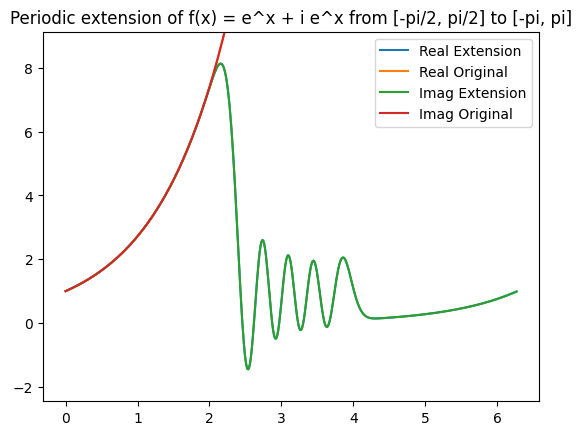

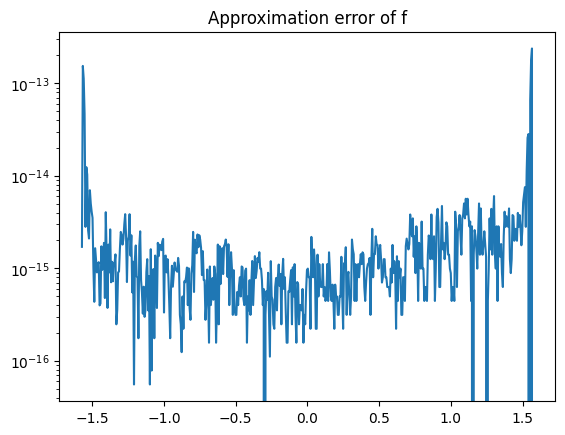

In [10]:
N     = 32
Ncoll = N * 2
theta = np.pi 
chi   = theta/2 
cutoff = 1e-14
def func(x):
    return np.exp(x) + 1j * np.exp(x) 

fext = FourierExtension( N, Ncoll, theta, chi, cutoff = cutoff)
x, dx = fext.getX()
f = func(x)
Ni = 512
xext = np.linspace(0, 2*theta, Ni+1)[:-1]
frec = fext.computeExtension(f, xext, maxiter=10)

plt.title("Periodic extension of f(x) = e^x + i e^x from [-pi/2, pi/2] to [-pi, pi]")
plt.plot(xext, frec.real,       label="Real Extension") 
plt.plot(xext, func(xext).real, label="Real Original") 
plt.plot(xext, frec.imag,       label="Imag Extension") 
plt.plot(xext, func(xext).imag, label="Imag Original") 
plt.legend()
plt.ylim(np.min(frec) - 1, np.max(frec) + 1)
plt.show() 

xext = np.linspace(-chi, chi, Ni)
frec = fext.computeExtension(f, xext, maxiter=10)
forg = func(xext)

fext.plotApproximationErorr(xext, forg, frec)

## Switch to arbitrary grid

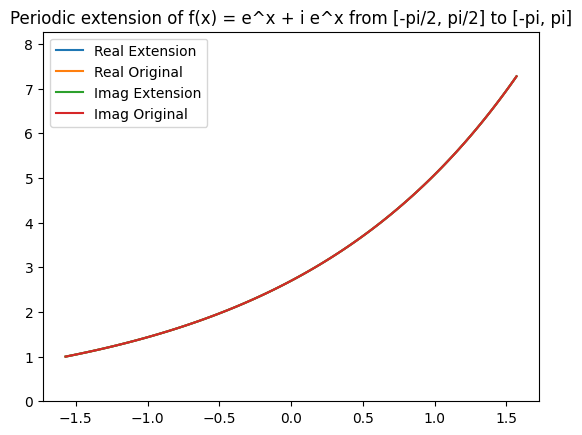

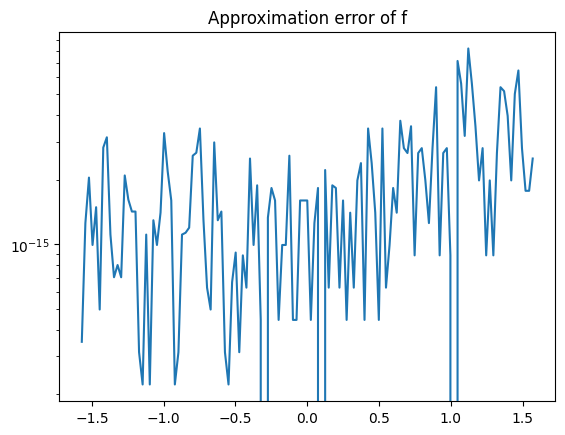

In [11]:
def func(x):
    return np.exp(x) + 1j * np.exp(x) 

#Start with f on arbitrary domain with even number of points
x = np.linspace(0, 2, 128)
L0 = x[ 0]
L1 = x[-2]
f = func(x)

Ncoll = int((len(x))/2) #x = 0 and 31 points in each direction
N     = int(Ncoll/2)
theta = np.pi 
chi   = theta/2 
cutoff = 1e-14

fext = FourierExtension( N, Ncoll, theta, chi, cutoff = cutoff)

Ni   = 512

xext = fext.x#np.linspace(L0, L1, 128)
frec = fext.computeExtension(f[:-1], xext, maxiter=10)
forg = f[:-1]
plt.title("Periodic extension of f(x) = e^x + i e^x from [-pi/2, pi/2] to [-pi, pi]")
plt.plot(xext, frec.real,       label="Real Extension") 
plt.plot(xext, forg.real, label="Real Original") 
plt.plot(xext, frec.imag,       label="Imag Extension") 
plt.plot(xext, forg.imag, label="Imag Original") 
plt.legend()
plt.ylim(np.min(frec) - 1, np.max(frec) + 1)
plt.show() 

xext = fext.x#np.linspace(L0, L1, 128)
frec = fext.computeExtension(f[:-1], xext, maxiter=10)
forg = f[:-1]

fext.plotApproximationErorr(xext, forg, frec)

## The all-in-one solution with inverse FFT

In [12]:
import numpy as np 
import matplotlib.pyplot as plt 
import scipy

class FourierExtension:
    def __init__(self, N, Ncoll, theta, chi, cutoff):
        self.N, self.Ncoll, self.theta, self.chi, self.cutoff = N, Ncoll, theta, chi, cutoff 
        self.Meven = self.getFPICSUEvenMatrix(N, Ncoll, theta, chi) 
        self.Modd  = self.getFPICSUOddMatrix (N, Ncoll, theta, chi) 

        self.dx    = chi / (Ncoll - 1) 
        self.x     = np.arange(-Ncoll + 1, Ncoll) * self.dx


        self.Meveninv  = self.invertRealM(self.Meven, cutoff)
        self.Moddinv   = self.invertRealM(self.Modd,  cutoff)

    def getX(self): 
        return self.x, self.dx
    
    def getFPICSUEvenMatrix(self, N, Ncoll, theta, chi): 
        M  = np.zeros((Ncoll, N))
        dx = chi / (Ncoll - 1) 
        for i in range(Ncoll):
            for j in range(N):
                #Collocation points uniformly distributed over the positive half
                #of the physical interval x in [0, chi]
                M[i, j] = np.cos(j * np.pi / theta * i * dx)
        return M

    def getFPICSUOddMatrix(self, N, Ncoll, theta, chi): 
        M = np.zeros((Ncoll, N))
        dx = chi / (Ncoll - 1) 
        for i in range(Ncoll):
            for j in range(N):
                #Collocation points uniformly distributed over the positive half
                #of the physical interval x in [0, chi]
                M[i, j] = np.sin(j * np.pi / theta * i * dx)
        return M

    def invertRealM(self, M, cutoff):
        U, s, Vh = scipy.linalg.svd(M)
        sinv = np.zeros(M.T.shape)
        for i in range(np.min(M.shape)):
            if s[i] < cutoff:
                sinv[i, i] = 0
            else:
                sinv[i, i] = 1/s[i]
        return Vh.T @ sinv @ U.T
    
    
    def convertToFourierCoeff(self, aodd, aeven):
        k = np.arange(-self.N, self.N) * np.pi / self.theta
        fhat = np.zeros(2*self.N, dtype=complex)

        for j, (oddcoeff, evecoeff) in enumerate(zip(aodd, aeven)):
            fhat[ j + self.N] +=   oddcoeff / (2j) + evecoeff / (2)
            fhat[-j + self.N] += - oddcoeff / (2j) + evecoeff / (2)


        return np.fft.ifftshift(fhat), np.fft.ifftshift(k) 

    def reconstructFourier(self, x, fhat, derivative_order = 0): 
        rec  = np.zeros (   x.shape, dtype=complex) 
        ks   = np.fft.ifftshift(np.arange( -self.N, self.N) * np.pi / self.theta)
        for k, coeff in zip(ks, fhat): 
            rec += coeff * (1j * k) ** derivative_order * np.exp(1j * k * x)
        return rec
    
    def iterativeRefinement(self, M, Minv, f, threshold = 100, maxiter = 5): 
        a       = Minv @ f
        r       = M @ a - f
        counter = 0
        while np.linalg.norm(r) > 100 * np.finfo(float).eps * np.linalg.norm(a) and counter < maxiter: 
            delta    = Minv @ r
            a        = a - delta 
            r        = M @ a - f
            counter += 1
        return a

    def computeExtension(self, f, Ni, threshold = 10, maxiter = 3): 
        refeven  = ((f + np.flip(f)).real/2)[self.Ncoll-1:]
        refodd   = ((f - np.flip(f)).real/2)[self.Ncoll-1:]
        imfeven  = ((f + np.flip(f)).imag/2)[self.Ncoll-1:]
        imfodd   = ((f - np.flip(f)).imag/2)[self.Ncoll-1:]
        aeven    = self.iterativeRefinement(self.Meven, self.Meveninv, refeven, threshold = threshold, maxiter = maxiter) + 1j * self.iterativeRefinement(self.Meven, self.Meveninv, imfeven, threshold = threshold, maxiter = maxiter)
        aodd     = self.iterativeRefinement(self.Modd,  self.Moddinv,  refodd,  threshold = threshold, maxiter = maxiter) + 1j * self.iterativeRefinement(self.Modd,  self.Moddinv,  imfodd,  threshold = threshold, maxiter = maxiter)
        #frec     = self.reconstructOdd(xext, aodd, self.theta) + self.reconstructEven(xext, aeven, self.theta) 
        fhat, k  = self.convertToFourierCoeff(aodd, aeven) 
        frec     = self.fourierInterpolation(fhat, Ni)
        return frec, fhat
    
    def fourierInterpolation(self, fhat, Ni):
        N = len(fhat) 
        Npad = int(Ni/2 - N/2) 
        ft   = np.fft.fftshift(fhat)
        ft_pad = np.concatenate([np.zeros(Npad), ft, np.zeros(Npad)])
        fint = scipy.fft.ifft(np.fft.fftshift(ft_pad), norm="forward")
        return fint
    
    def rescaleToPhysical(self, x, getSlope = False): 
        a = x[0]
        b = x[-1]
        L = b -a 
        sx = ( x - a ) / L
        sx = sx * (2*self.chi) - self.chi
        if getSlope:

            return sx, a * 2 * chi / L + chi, 2 * chi / L 
        else:
            return sx 

    def rescaleToExtended(self, x, getSlope = False):  
        a = x[0]
        b = x[-1]
        sx = ( x - a ) / ( b - a ) 
        sx = sx * (2*self.theta) - self.theta
        if getSlope:
            return sx, a, b - a
        else:
            return sx 
    
    def plotApproximationErorr(self, xext, forg, frec):
        plt.title("Approximation error of f")
        plt.yscale("log")
        plt.plot(xext, np.abs(forg - frec))
        plt.show() 


/home/calab912/.local/lib/python3.8/site-packages/matplotlib/transforms.py:2877: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


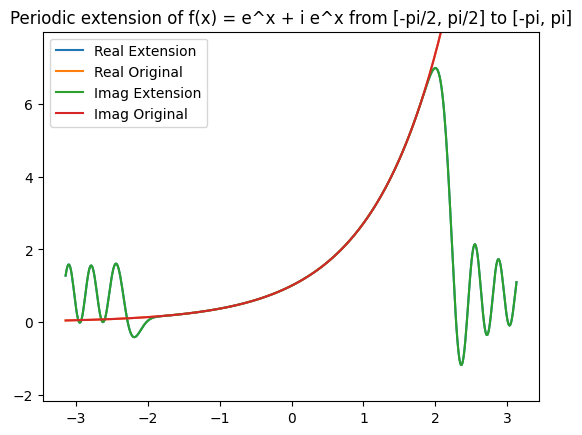

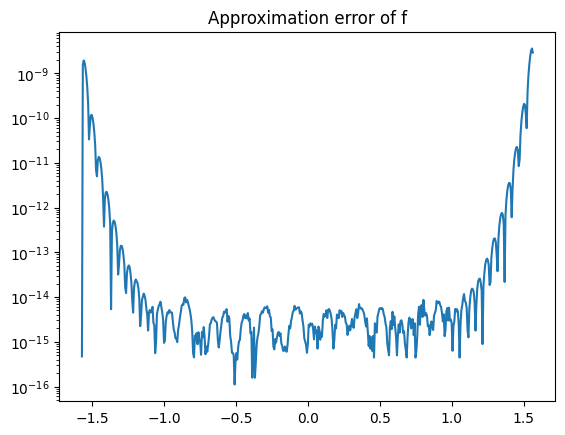

In [13]:
N     = 32
Ncoll = N
theta = np.pi 
chi   = theta/2 
cutoff = 1e-14
def func(x):
    return np.exp(x) + 1j * np.exp(x) 

fext = FourierExtension( N, Ncoll, theta, chi, cutoff = cutoff)
x, dx = fext.getX()
f = func(x)
Ni = 512
xext = np.linspace(-theta, theta, Ni+1)[:-1]

frec, fhat = fext.computeExtension(f, Ni, maxiter=10)
frec = fext.reconstructFourier(xext, fhat)

plt.title("Periodic extension of f(x) = e^x + i e^x from [-pi/2, pi/2] to [-pi, pi]")
plt.plot(xext, frec.real,       label="Real Extension") 
plt.plot(xext, func(xext).real, label="Real Original") 
plt.plot(xext, frec.imag,       label="Imag Extension") 
plt.plot(xext, func(xext).imag, label="Imag Original") 
plt.legend()
plt.ylim(np.min(frec) - 1, np.max(frec) + 1)
plt.show() 

xext = np.linspace(-chi, chi, Ni+1)[:-1]
forg = func(xext)
frec = fext.reconstructFourier(xext, fhat)
fext.plotApproximationErorr(xext, forg, frec)

## Extend to arbitrary domains

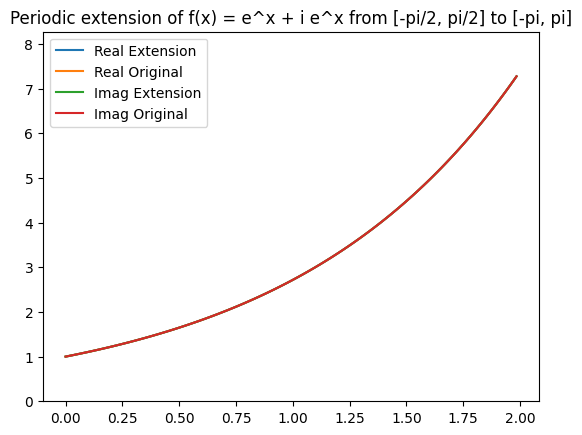

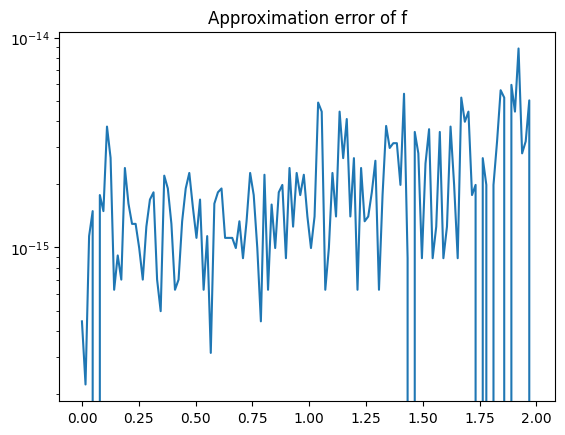

In [14]:
def func(x):
    return np.exp(x) + 1j * np.exp(x) 

#Start with f on arbitrary domain with even number of points
x = np.linspace(0, 2, 128)
L0 = x[ 0]
L1 = x[-2]
f = func(x)

Ncoll = int((len(x))/2) #x = 0 and 31 points in each direction
N     = int(Ncoll/2)
theta = np.pi 
chi   = theta/2 
cutoff = 1e-14

fext = FourierExtension( N, Ncoll, theta, chi, cutoff = cutoff)


xext = x[:-1]#np.linspace(L0, L1, 128)
frec, fhat = fext.computeExtension(f[:-1], len(x), maxiter=10)
frec       = fext.reconstructFourier(fext.rescaleToPhysical(x[:-1]), fhat) 
forg = f[:-1]
plt.title("Periodic extension of f(x) = e^x + i e^x from [-pi/2, pi/2] to [-pi, pi]")
plt.plot(xext, frec.real,       label="Real Extension") 
plt.plot(xext, forg.real, label="Real Original") 
plt.plot(xext, frec.imag,       label="Imag Extension") 
plt.plot(xext, forg.imag, label="Imag Original") 
plt.legend()
plt.ylim(np.min(frec) - 1, np.max(frec) + 1)
plt.show() 

fext.plotApproximationErorr(xext, forg, frec)

### Compute derivative

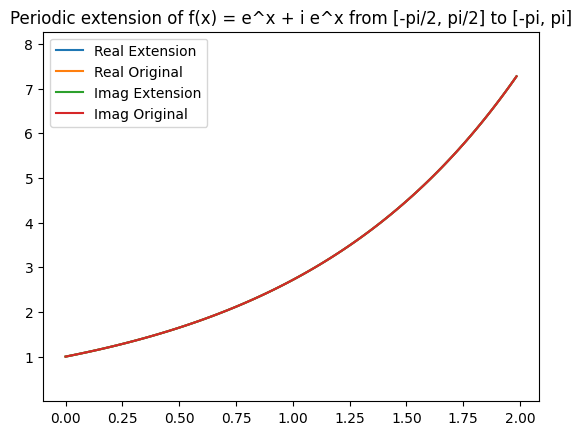

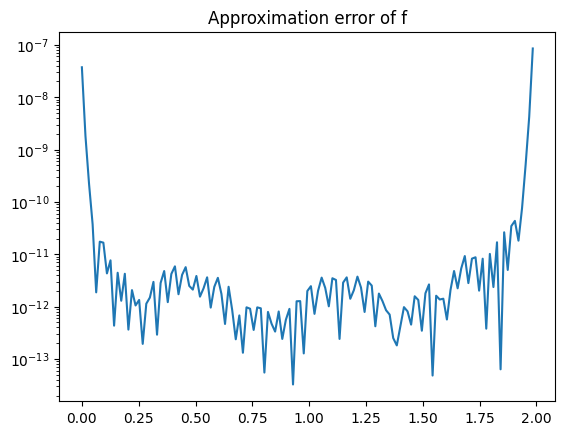

In [15]:
def func(x):
    return np.exp(x) + 1j * np.exp(x) 

#Start with f on arbitrary domain with even number of points
x = np.linspace(0, 2, 128)
L0 = x[ 0]
L1 = x[-2]
f = func(x)

Ncoll = int((len(x))/2) #x = 0 and 31 points in each direction
N     = int(Ncoll/2)
theta = np.pi 
chi   = theta/2 
cutoff = 1e-14

fext = FourierExtension( N, Ncoll, theta, chi, cutoff = cutoff)


xext = x[:-1]#np.linspace(L0, L1, 128)
frec, fhat = fext.computeExtension(f[:-1], len(x), maxiter=10)
frec       = fext.reconstructFourier(fext.rescaleToPhysical(x[:-1]), fhat, derivative_order=2) * (np.pi/(x[-2] - x[0]))**2
forg = f[:-1]
plt.title("Periodic extension of f(x) = e^x + i e^x from [-pi/2, pi/2] to [-pi, pi]")
plt.plot(xext, frec.real,       label="Real Extension") 
plt.plot(xext, forg.real, label="Real Original") 
plt.plot(xext, frec.imag,       label="Imag Extension") 
plt.plot(xext, forg.imag, label="Imag Original") 
plt.legend()
plt.ylim(np.min(frec) - 1, np.max(frec) + 1)
plt.show() 

fext.plotApproximationErorr(xext, forg, frec)

### Use FFT with extended domain but original data where possible

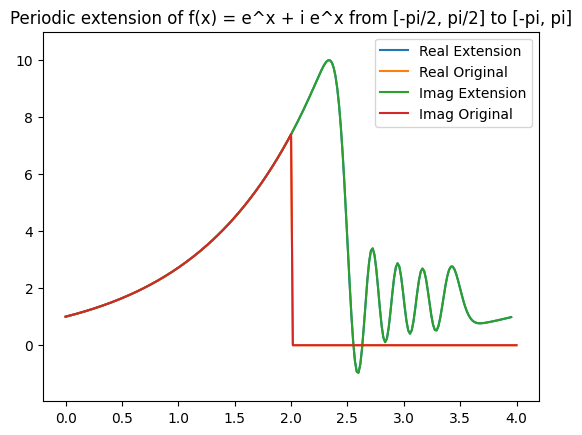

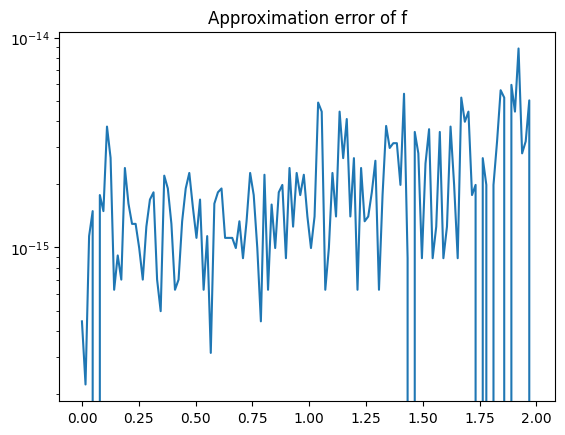

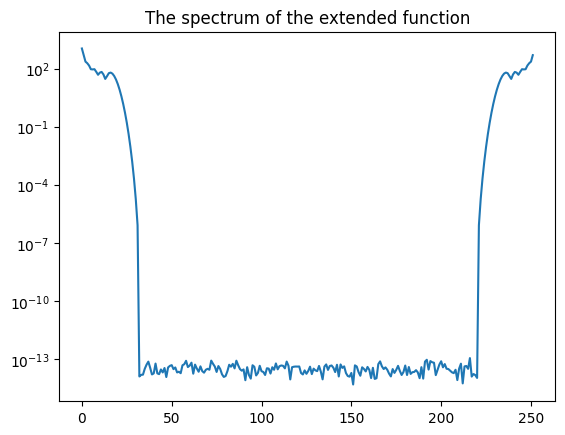

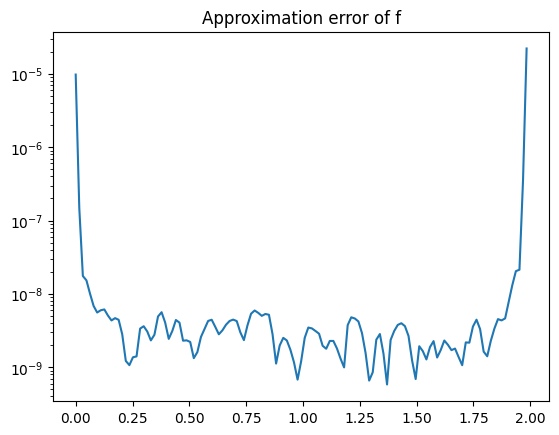

In [16]:
def func(x):
    return np.exp(x) + 1j * np.exp(x) 

#Start with f on arbitrary domain with even number of points
Nfull = 128
x = np.linspace(0, 2, Nfull)
dx = x[1] - x[0]
L0 = x[ 0]
L1 = x[-2]
f = func(x)

Ncoll = int((len(x))/2) #x = 0 and 31 points in each direction
N     = int(Ncoll/2)
theta = np.pi 
chi   = theta/2 
cutoff = 1e-14

fext = FourierExtension( N, Ncoll, theta, chi, cutoff = cutoff)

xscale, shift, slope = fext.rescaleToPhysical(x[:-1], getSlope=True)
dx     = xscale[1] - xscale[0]
xint   = np.pad(xscale, (0, Nfull), mode="linear_ramp", end_values=(0, xscale[-1] + Nfull * dx))
xext   = (xint + shift)/slope
frec, fhat = fext.computeExtension(f[:-1], len(x), maxiter=10)
frec       = fext.reconstructFourier(xint, fhat)[:-3]#, derivative_order=2) * (np.pi/(xext[-2] - xext[0]))**2

forg = np.pad(f, (0, Nfull - 1), mode="constant")
plt.title("Periodic extension of f(x) = e^x + i e^x from [-pi/2, pi/2] to [-pi, pi]")
plt.plot(xext[:-3], frec.real,       label="Real Extension") 
plt.plot(xext, forg.real, label="Real Original") 
plt.plot(xext[:-3], frec.imag,       label="Imag Extension") 
plt.plot(xext, forg.imag, label="Imag Original") 
plt.legend()
plt.ylim(np.min(frec) - 1, np.max(frec) + 1)
plt.show() 

fext.plotApproximationErorr(x[:-1], forg[:Nfull-1], frec[:Nfull-1])

frec[:Nfull-1] = forg[:Nfull-1]

fhat = scipy.fft.fft(frec)
plt.title("The spectrum of the extended function") 
plt.yscale("log") 
plt.plot(np.abs(fhat)) 
plt.show()

import spectral_derivative as sd 

k = sd.computeK(fhat, x[1] - x[0], sd.PERIODIC)
derivative_order = 3
fhat = fhat * (1j*k)**derivative_order
frec = scipy.fft.ifft(fhat) 

fext.plotApproximationErorr(x[:-1], forg[:Nfull-1], frec[:Nfull-1])


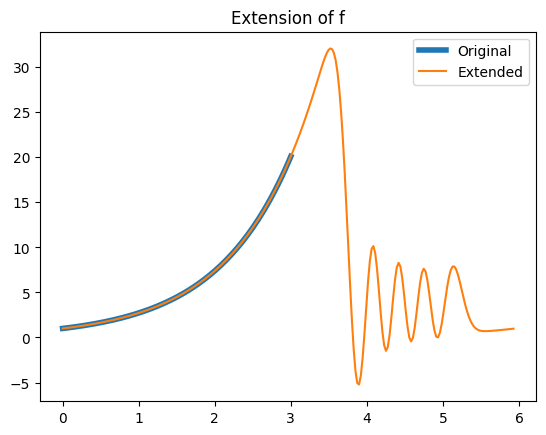

In [25]:
def func(x):
    return np.exp(x) + 1j * np.exp(x) 

#Start with f on arbitrary domain with even number of points
Nfull = 128
x = np.linspace(0, 3, Nfull)
f = func(x)

def getExtendedFunction(f, x, NNcollRatio = 0.5, cutoff = 1e-14, maxiter = 3): 
    Nfull = len(x) 
    Ncoll = int((len(x))/2) #x = 0 and 31 points in each direction
    N     = int(Ncoll * NNcollRatio)
    theta = np.pi 
    chi   = theta/2 

    fext = FourierExtension( N, Ncoll, theta, chi, cutoff = cutoff)
    
    xscale, shift, slope = fext.rescaleToPhysical(x[:-1], getSlope=True)
    dx                   = xscale[1] - xscale[0]
    xint                 = np.pad(xscale, (0, Nfull), mode="linear_ramp", end_values=(0, xscale[-1] + Nfull * dx))
    xext                 = (xint + shift)/slope
    frec, fhat           = fext.computeExtension(f[:-1], (len(x)-2)*2, maxiter=maxiter)
    frec                 = np.roll(frec, Ncoll - 1)
   

    frec[:Nfull-1] = f[:-1]
    return xext, frec

xext, fext = getExtendedFunction(f, x)

plt.title("Extension of f")
plt.plot(x, f, lw = 4, label="Original")
plt.plot(xext[:-3], fext, label="Extended")
plt.legend()
plt.show()

## Test continuity of derivatives after shift using FFT

/home/calab912/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


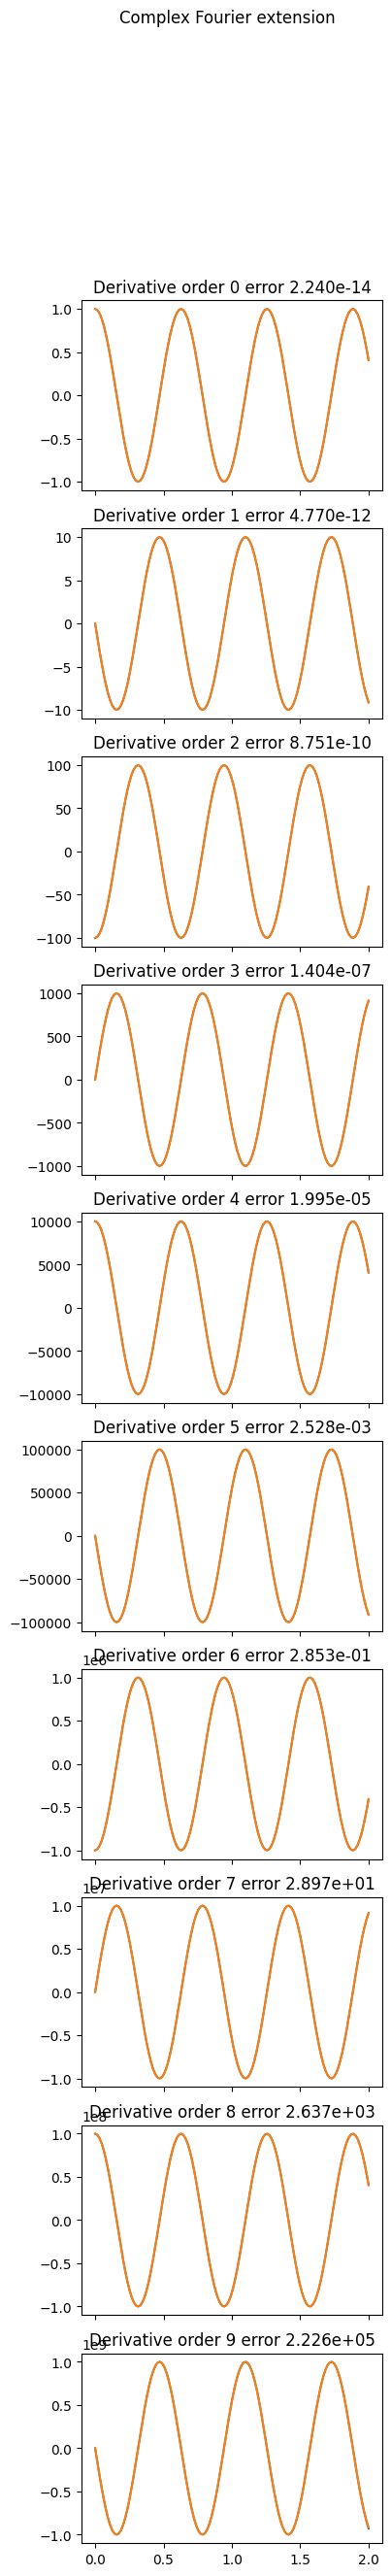

In [30]:
import spectral_derivative as sd 
Nfull = 128 
x = np.linspace(0, 2, Nfull)
dx = x[1] - x[0]
def func(x, derivative_order=0): 
    return np.real((1j*10)**derivative_order*np.exp(1j*10*x))
    #return np.imag((1j*np.pi)**derivative_order*np.exp(1j*np.pi*x))

f = func(x)

N_derivative = 10

fig, ax = plt.subplots(N_derivative, 1, sharex=True, figsize=(4,N_derivative*3)) 
fig.suptitle(f"Complex Fourier extension")
for i in range(N_derivative): 
    xext, fext = getExtendedFunction(f, x, maxiter=10) 
    k    = sd.computeK(fext, dx, sd.PERIODIC)
    fhat = scipy.fft.fft(fext)
    frec = scipy.fft.ifft(fhat * (1j*k)**(i))
    sumo = frec[:Nfull]
    

    fref = func(x, i) 
    ax[i].set_title(f"Derivative order {i} error {np.mean(np.abs(sumo-fref)):3.3e}")
    ax[i].plot(x, sumo, label="sum") 
    ax[i].plot(x, fref, label="ref") 
    
plt.savefig(f"complex_fe_order.png")
plt.show()
plt.close()

## Check decay of Fourier coefficients for different test functions

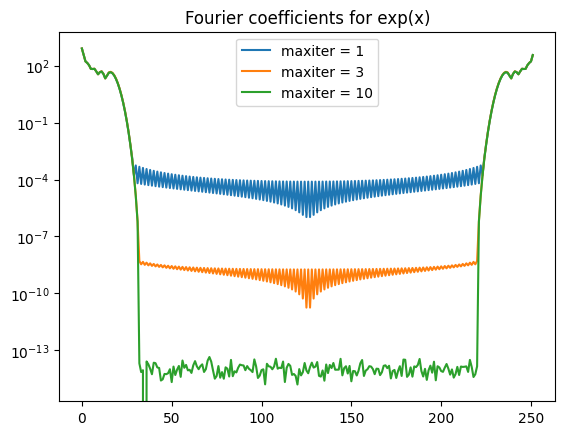

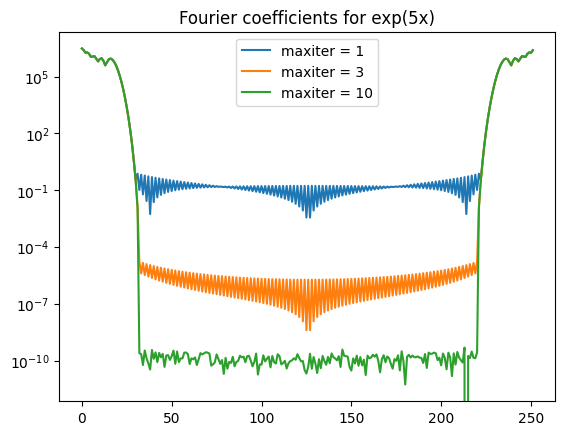

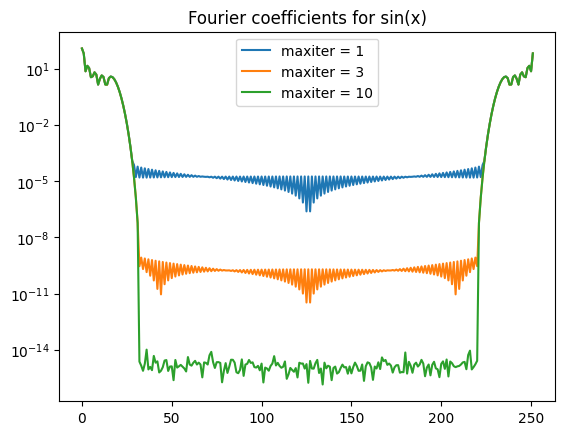

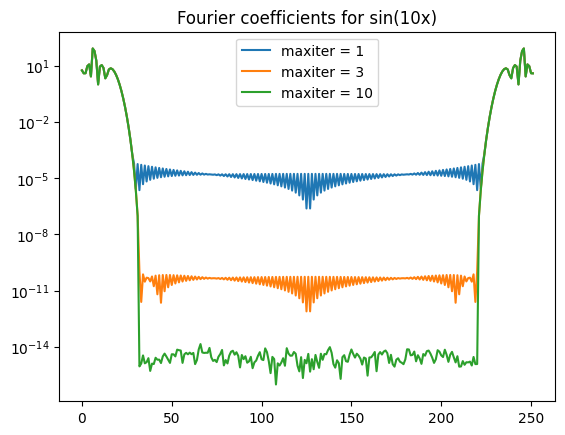

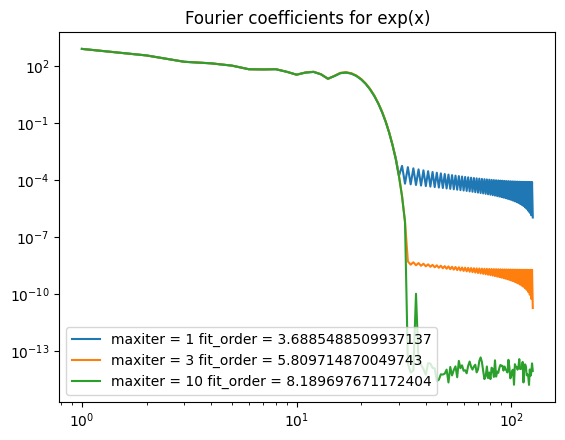

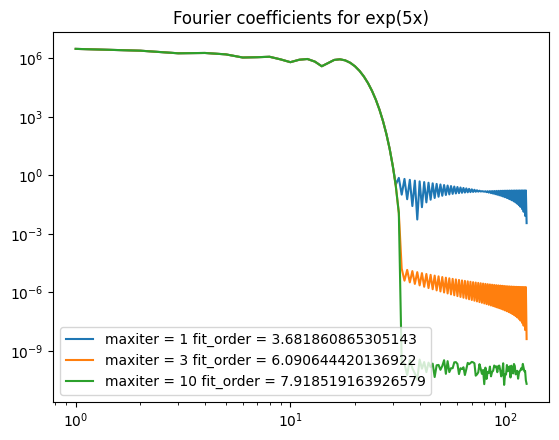

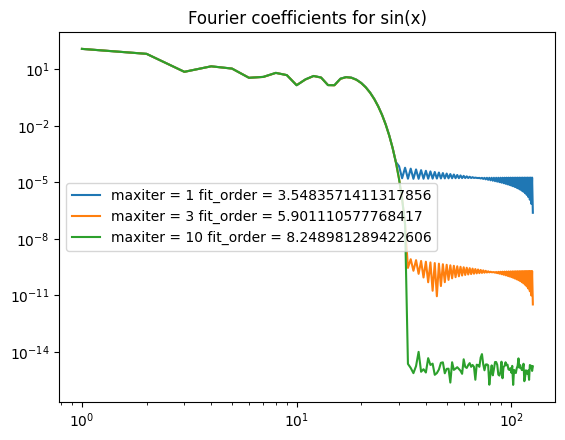

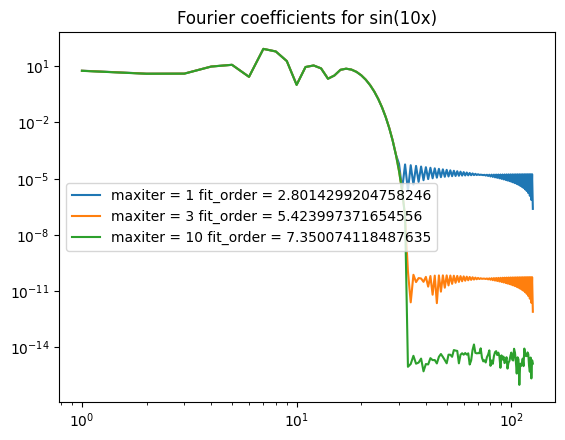

In [40]:

x = np.linspace(0, 2, 128)
fs = [np.exp(x), np.exp(5*x), np.sin(x), np.sin(x*10)]
ns = ["exp(x)", "exp(5x)", "sin(x)", "sin(10x)"]

for f, n in zip(fs, ns): 
    plt.title(f"Fourier coefficients for {n}") 
    plt.yscale("log") 
    for maxiter in [1, 3, 10]: 
        xext, fext = getExtendedFunction(f, x, maxiter=maxiter, NNcollRatio=0.5) 
        k    = sd.computeK(fext, dx, sd.PERIODIC)
        fhat = scipy.fft.fft(fext)
        plt.plot(np.abs(fhat), label=f"maxiter = {maxiter}") 
    plt.legend()
    plt.show() 


for f, n in zip(fs, ns): 
    plt.title(f"Fourier coefficients for {n}") 
    for maxiter in [1, 3, 10]: 
        xext, fext = getExtendedFunction(f, x, maxiter=maxiter, NNcollRatio=0.5) 
        k    = sd.computeK(fext, dx, sd.PERIODIC)
        fhat = scipy.fft.fft(fext)
        y    = np.abs(fhat)
        y    = y[:int(len(y)/2)]
        y[y==0] = 1e-10
        r    = np.arange(1, len(y)+1)
        def fitfunc(x, beta): 
            return np.log(y[0]) + beta * np.log(x)
        coeff, cov = scipy.optimize.curve_fit(fitfunc, r, np.log(y)) 
        #print(coeff)
        plt.loglog(r, y, label=f"maxiter = {maxiter} fit_order = {np.abs(coeff[0])}") 
        #plt.loglog(r, np.exp(fitfunc(r, coeff[0])), label=f"fit with {y[0]} * x ** {coeff[0]}") 
    plt.legend()
    plt.show() 